<a href="https://colab.research.google.com/github/nhatnguyen3104/lttt_polarCode/blob/main/Polar_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

abc


Khởi tạo các mã...
Bắt đầu mô phỏng...
Mô phỏng Polar N=8...
SNR = 0.0 dB, BER = 0.407000
SNR = 0.5 dB, BER = 0.413500
SNR = 1.0 dB, BER = 0.389500
SNR = 1.5 dB, BER = 0.409000
SNR = 2.0 dB, BER = 0.405000
SNR = 2.5 dB, BER = 0.387000
SNR = 3.0 dB, BER = 0.387500
SNR = 3.5 dB, BER = 0.380000
SNR = 4.0 dB, BER = 0.398000
SNR = 4.5 dB, BER = 0.390500
SNR = 5.0 dB, BER = 0.389000
SNR = 5.5 dB, BER = 0.376500

Mô phỏng Polar N=16...
SNR = 0.0 dB, BER = 0.452500
SNR = 0.5 dB, BER = 0.465000
SNR = 1.0 dB, BER = 0.459250
SNR = 1.5 dB, BER = 0.447000
SNR = 2.0 dB, BER = 0.445250
SNR = 2.5 dB, BER = 0.461500
SNR = 3.0 dB, BER = 0.441500
SNR = 3.5 dB, BER = 0.445000
SNR = 4.0 dB, BER = 0.441750
SNR = 4.5 dB, BER = 0.446500
SNR = 5.0 dB, BER = 0.444000
SNR = 5.5 dB, BER = 0.440250

Mô phỏng Polar N=32...
SNR = 0.0 dB, BER = 0.477250
SNR = 0.5 dB, BER = 0.476000
SNR = 1.0 dB, BER = 0.484000
SNR = 1.5 dB, BER = 0.490000
SNR = 2.0 dB, BER = 0.462500
SNR = 2.5 dB, BER = 0.471875
SNR = 3.0 dB, BER = 0

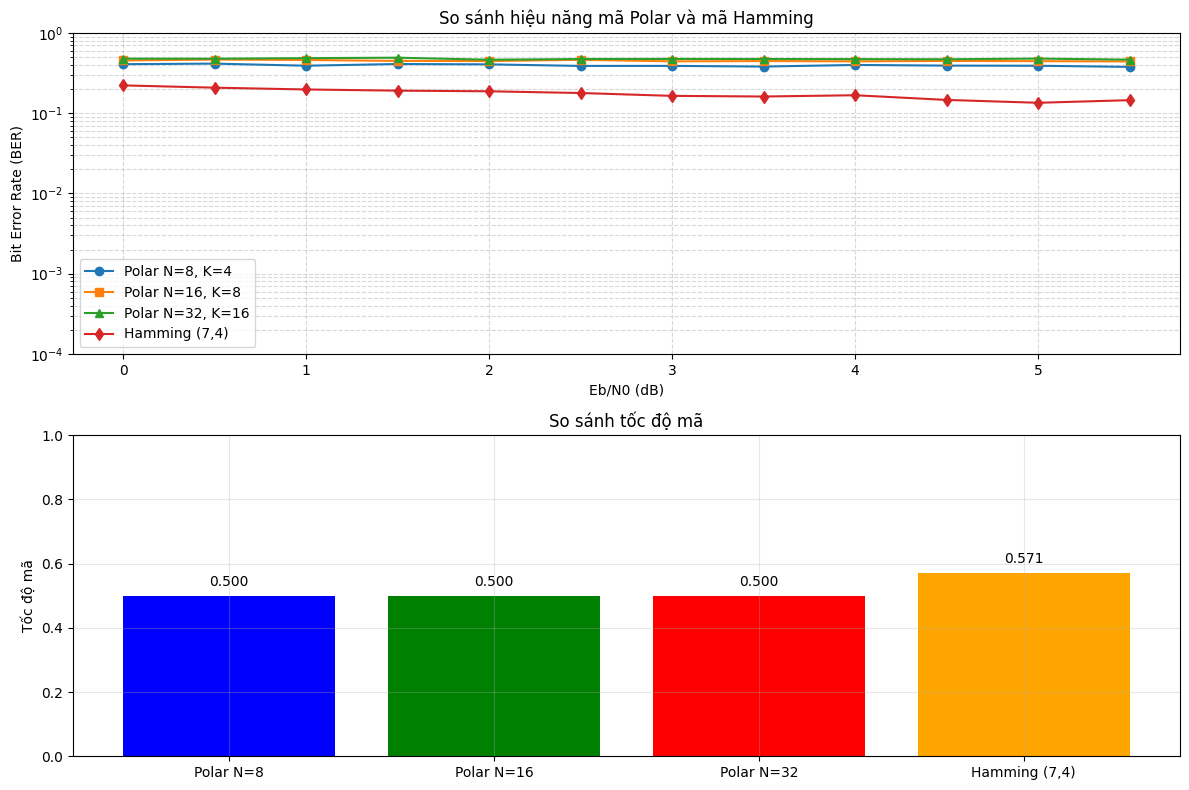


Thông tin các mã:
Polar N=8:  tốc độ = 0.500, bit thông tin = 4
Polar N=16: tốc độ = 0.500, bit thông tin = 8
Polar N=32: tốc độ = 0.500, bit thông tin = 16
Hamming(7,4): tốc độ = 0.571

Kiểm tra mã hóa/giải mã cơ bản:
Bit thông tin test: [1 0 1 0]
Polar N=8 - Mã hóa: [0 0 1 0 0 0 0 0], Giải mã: [0 0 1 0]
Hamming(7,4) - Mã hóa: [1 0 1 0 1 0 1], Giải mã: [1 0 1 0]


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import erfc

class PolarCode:
    def __init__(self, N, K):
        """
        Khởi tạo mã Polar

        Parameters:
        N: Độ dài mã (phải là lũy thừa của 2)
        K: Số bit thông tin
        """
        self.N = N
        self.K = K
        self.n = int(np.log2(N))

        # Tính độ tin cậy các kênh
        self.Z = self.calculate_reliabilities()

        # Chọn K kênh tốt nhất để truyền bit thông tin
        self.info_positions = np.argsort(self.Z)[:self.K]
        self.frozen_positions = np.setdiff1d(np.arange(N), self.info_positions)

        # Ma trận mã hóa Polar
        self.G = self.generate_polar_matrix()

    def calculate_reliabilities(self):
        """Tính độ tin cậy các kênh bằng phương pháp đệ quy"""
        N = self.N
        n = self.n

        # Khởi tạo với kênh gốc
        Z = np.zeros(N)
        Z[0] = 0.5  # Giả sử xác suất lỗi ban đầu

        # Tính toán đệ quy
        for i in range(n):
            step = 2 ** i
            for j in range(0, N, 2 * step):
                for k in range(j, j + step):
                    z1 = Z[k]
                    z2 = Z[k + step]
                    Z[k] = z1 * z2  # Z_minus
                    Z[k + step] = 1 - (1 - z1) * (1 - z2)  # Z_plus

        return Z

    def generate_polar_matrix(self):
        """Tạo ma trận mã hóa Polar GN = F tensor n"""
        # Ma trận kernel
        F = np.array([[1, 0], [1, 1]])

        # Tính tích Kronecker
        G = F.copy()
        for _ in range(self.n - 1):
            G = np.kron(G, F)

        return G % 2  # Lấy modulo 2

    def encode(self, info_bits):
        """Mã hóa bit thông tin thành từ mã"""
        # Tạo vector u với bit đóng băng = 0
        u = np.zeros(self.N, dtype=int)
        u[self.info_positions] = info_bits

        # Mã hóa: x = u * G mod 2
        codeword = np.dot(u, self.G) % 2
        return codeword

    def sc_decode(self, received_llrs):
        """Giải mã bằng Successive Cancellation (phiên bản đơn giản)"""
        N = self.N

        # Khởi tạo các biến
        u_hat = np.zeros(N, dtype=int)

        # Giải mã tuần tự từng bit
        for i in range(N):
            if i in self.frozen_positions:
                u_hat[i] = 0  # Bit đóng băng
            else:
                # Quyết định dựa trên LLR
                u_hat[i] = 0 if received_llrs[i] >= 0 else 1

        # Trích xuất bit thông tin
        decoded_info = u_hat[self.info_positions]
        return decoded_info

class HammingCode:
    def __init__(self, m):
        """
        Khởi tạo mã Hamming

        Parameters:
        m: Số bit kiểm tra, độ dài mã n = 2^m - 1
        """
        self.m = m
        self.n = 2**m - 1
        self.k = self.n - m

        # Tạo ma trận kiểm tra H
        self.H = self.generate_parity_check_matrix()

        # Tạo ma trận sinh G
        self.G = self.generate_generator_matrix()

    def generate_parity_check_matrix(self):
        """Tạo ma trận kiểm tra H cho mã Hamming"""
        H = np.zeros((self.m, self.n), dtype=int)

        # Các cột của H là các số từ 1 đến 2^m - 1 viết dưới dạng nhị phân
        for i in range(1, self.n + 1):
            binary = format(i, f'0{self.m}b')
            for j in range(self.m):
                H[j, i-1] = int(binary[j])

        return H

    def generate_generator_matrix(self):
        """Tạo ma trận sinh G cho mã Hamming"""
        # Tạo ma trận hệ thống G = [I_k | P]
        # Tìm ma trận P từ H = [P^T | I_m]

        # Sắp xếp các cột của H để có dạng hệ thống
        H_systematic = np.zeros((self.m, self.n), dtype=int)

        # Tìm các vị trí cho bit kiểm tra (các cột là vector đơn vị)
        parity_positions = []
        for i in range(self.m):
            parity_positions.append(2**i - 1)

        # Điền các cột cho bit thông tin và bit kiểm tra
        info_col = 0
        for i in range(self.n):
            if i in parity_positions:
                continue
            H_systematic[:, i] = self.H[:, info_col]
            info_col += 1

        # Điền các cột bit kiểm tra (vector đơn vị)
        for i, pos in enumerate(parity_positions):
            H_systematic[i, pos] = 1

        # Trích xuất ma trận P từ H = [P^T | I_m]
        P_transpose = H_systematic[:, :self.k]
        P = P_transpose.T

        # Tạo ma trận sinh G = [I_k | P]
        I_k = np.eye(self.k, dtype=int)
        G = np.hstack([I_k, P])

        return G

    def encode(self, info_bits):
        """Mã hóa bit thông tin thành từ mã"""
        return np.mod(np.dot(info_bits, self.G), 2)

    def decode(self, received_bits):
        """Giải mã bằng syndrome decoding"""
        # Tính syndrome
        syndrome = np.mod(np.dot(self.H, received_bits), 2)

        # Chuyển syndrome thành số thập phân
        error_position = 0
        for i in range(self.m):
            error_position += syndrome[i] * (2**(self.m-1-i))

        # Sửa lỗi nếu có
        decoded_bits = received_bits.copy()
        if error_position > 0:
            decoded_bits[error_position-1] = 1 - decoded_bits[error_position-1]

        # Trích xuất bit thông tin (giả sử systematic)
        decoded_info = decoded_bits[:self.k]
        return decoded_info

def simulate_ber(snr_db_list, code, num_frames=1000):
    """
    Mô phỏng BER cho một mã cụ thể
    """
    ber_list = []

    for snr_db in snr_db_list:
        # Chuyển đổi SNR từ dB sang tỷ lệ tuyến tính
        snr_linear = 10**(snr_db / 10)

        # Tính phương sai nhiễu
        if hasattr(code, 'k'):  # Mã Hamming
            code_rate = code.k / code.n
        else:  # Mã Polar
            code_rate = code.K / code.N

        noise_variance = 1 / (2 * code_rate * snr_linear)

        error_bits = 0
        total_bits = 0

        for _ in range(num_frames):
            # Tạo bit thông tin ngẫu nhiên
            if hasattr(code, 'k'):  # Mã Hamming
                info_bits = np.random.randint(0, 2, code.k)
            else:  # Mã Polar
                info_bits = np.random.randint(0, 2, code.K)

            # Mã hóa
            codeword = code.encode(info_bits)

            # Điều chế BPSK: 0 -> +1, 1 -> -1
            modulated = 1 - 2 * codeword

            # Thêm nhiễu Gauss
            noise = np.sqrt(noise_variance) * np.random.randn(len(modulated))
            received = modulated + noise

            # Giải mã
            if hasattr(code, 'k'):  # Mã Hamming
                # Giải điều chế và làm tròn về 0/1
                demodulated = (received < 0).astype(int)
                decoded_info = code.decode(demodulated)
            else:  # Mã Polar
                # Tính LLR từ tín hiệu nhận được
                llrs = 2 * received / noise_variance
                decoded_info = code.sc_decode(llrs)

            # Đếm số bit lỗi
            error_bits += np.sum(info_bits != decoded_info)
            total_bits += len(info_bits)

        ber = error_bits / total_bits if total_bits > 0 else 1
        ber_list.append(ber)

        print(f"SNR = {snr_db:.1f} dB, BER = {ber:.6f}")

    return ber_list

# Tham số mô phỏng
snr_db_list = np.arange(0, 6, 0.5)
num_frames = 500

print("Khởi tạo các mã...")

# Tạo các mã Polar
polar_N8 = PolarCode(N=8, K=4)
polar_N16 = PolarCode(N=16, K=8)
polar_N32 = PolarCode(N=32, K=16)

# Tạo mã Hamming
hamming_7_4 = HammingCode(m=3)  # (7,4) Hamming code

print("Bắt đầu mô phỏng...")

# Mô phỏng BER
print("Mô phỏng Polar N=8...")
ber_polar_N8 = simulate_ber(snr_db_list, polar_N8, num_frames)

print("\nMô phỏng Polar N=16...")
ber_polar_N16 = simulate_ber(snr_db_list, polar_N16, num_frames)

print("\nMô phỏng Polar N=32...")
ber_polar_N32 = simulate_ber(snr_db_list, polar_N32, num_frames)

print("\nMô phỏng Hamming (7,4)...")
ber_hamming = simulate_ber(snr_db_list, hamming_7_4, num_frames)

# Vẽ đồ thị BER
plt.figure(figsize=(12, 8))

plt.subplot(2, 1, 1)
plt.semilogy(snr_db_list, ber_polar_N8, 'o-', label='Polar N=8, K=4')
plt.semilogy(snr_db_list, ber_polar_N16, 's-', label='Polar N=16, K=8')
plt.semilogy(snr_db_list, ber_polar_N32, '^-', label='Polar N=32, K=16')
plt.semilogy(snr_db_list, ber_hamming, 'd-', label='Hamming (7,4)')

plt.xlabel('Eb/N0 (dB)')
plt.ylabel('Bit Error Rate (BER)')
plt.title('So sánh hiệu năng mã Polar và mã Hamming')
plt.grid(True, which='both', linestyle='--', alpha=0.5)
plt.legend()
plt.ylim(1e-4, 1)

# Vẽ đồ thị so sánh tốc độ mã
plt.subplot(2, 1, 2)
code_rates = [
    polar_N8.K / polar_N8.N,
    polar_N16.K / polar_N16.N,
    polar_N32.K / polar_N32.N,
    hamming_7_4.k / hamming_7_4.n
]

code_names = ['Polar N=8', 'Polar N=16', 'Polar N=32', 'Hamming (7,4)']

bars = plt.bar(code_names, code_rates, color=['blue', 'green', 'red', 'orange'])
plt.ylabel('Tốc độ mã')
plt.title('So sánh tốc độ mã')
plt.ylim(0, 1)

# Thêm giá trị trên các cột
for bar, rate in zip(bars, code_rates):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
             f'{rate:.3f}', ha='center', va='bottom')

plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# In thông tin các mã
print("\nThông tin các mã:")
print(f"Polar N=8:  tốc độ = {polar_N8.K/polar_N8.N:.3f}, bit thông tin = {polar_N8.K}")
print(f"Polar N=16: tốc độ = {polar_N16.K/polar_N16.N:.3f}, bit thông tin = {polar_N16.K}")
print(f"Polar N=32: tốc độ = {polar_N32.K/polar_N32.N:.3f}, bit thông tin = {polar_N32.K}")
print(f"Hamming(7,4): tốc độ = {hamming_7_4.k/hamming_7_4.n:.3f}")

# Kiểm tra mã hóa/giải mã cơ bản
print("\nKiểm tra mã hóa/giải mã cơ bản:")
info_test = np.array([1, 0, 1, 0])
print(f"Bit thông tin test: {info_test}")

# Test Polar N=8
codeword_polar = polar_N8.encode(info_test)
decoded_polar = polar_N8.sc_decode(2*(1-2*codeword_polar))  # Giả sử không có nhiễu
print(f"Polar N=8 - Mã hóa: {codeword_polar}, Giải mã: {decoded_polar}")

# Test Hamming
codeword_hamming = hamming_7_4.encode(info_test)
decoded_hamming = hamming_7_4.decode(codeword_hamming)
print(f"Hamming(7,4) - Mã hóa: {codeword_hamming}, Giải mã: {decoded_hamming}")